In [19]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
# 定义RMSLE公式
def rmsle(y: np.ndarray, y_pred: np.ndarray):
    return np.sqrt(1 / len(y) * np.sum((np.log(1 + y_pred) - np.log(1 + y))**2))

In [21]:
file_path = 'kaggle/input/playground-series-s5e5'
train_df = pd.read_csv(os.path.join(file_path, "train.csv"))
test_df = pd.read_csv(os.path.join(file_path, "test.csv"))
train_df['Sex'] = train_df['Sex'].map({'male': 1, 'female': 0})
test_df['Sex'] = test_df['Sex'].map({'male': 1, 'female': 0})
# # 检查空数据情况
# print("----Train data----")
# print(train_df.isnull().sum())
# print("----Test data----")
# print(test_df.isnull().sum())

# # 检查数据类型
# print("----Train data----")
# print(train_df.dtypes)

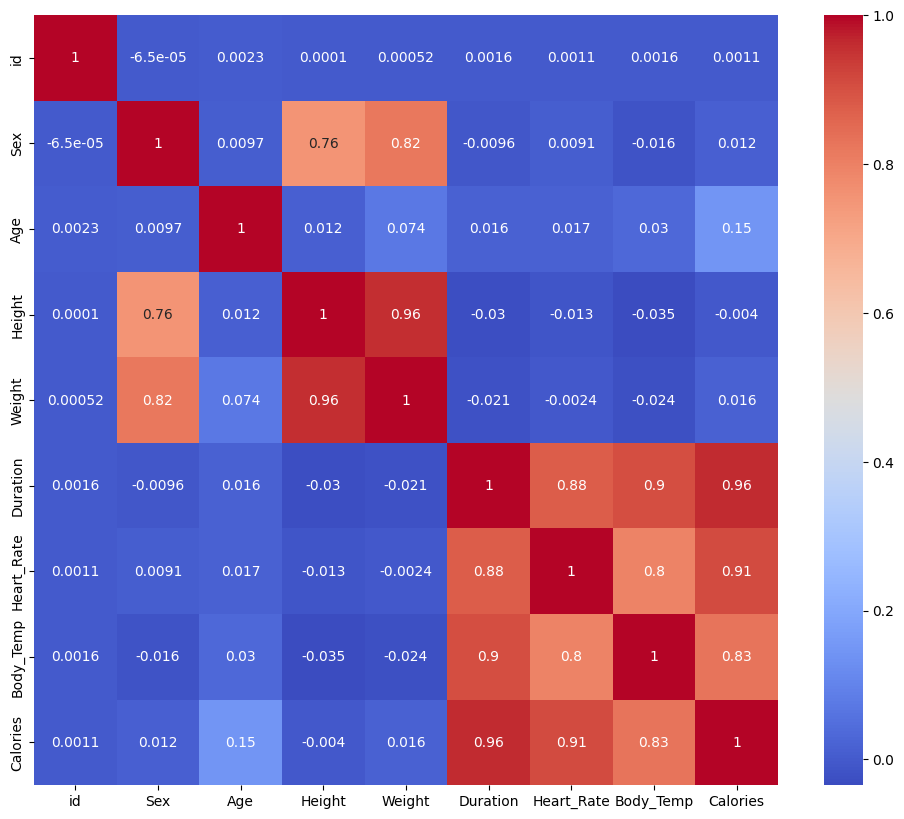

In [24]:
# 绘制相关性热图
# print(train_df.corr())

plt.figure(figsize=(12, 10))
sns.heatmap(train_df.corr(), annot=True, cmap='coolwarm')
plt.show()


[0]	train-rmse:56.34981	valid-rmse:56.18630


d:\code\kaggle\Predict-Calorie-Expenditure\.venv\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[10]	train-rmse:21.46991	valid-rmse:21.39108
[20]	train-rmse:9.25835	valid-rmse:9.21736
[30]	train-rmse:5.42327	valid-rmse:5.41759
[40]	train-rmse:4.26118	valid-rmse:4.28446
[50]	train-rmse:3.92828	valid-rmse:3.97639
[60]	train-rmse:3.79867	valid-rmse:3.86344
[70]	train-rmse:3.72748	valid-rmse:3.80438
[80]	train-rmse:3.68698	valid-rmse:3.77270
[90]	train-rmse:3.65130	valid-rmse:3.74819
[99]	train-rmse:3.62282	valid-rmse:3.72888
验证集RMSE: 3.7289
验证集MAE: 2.3053
验证集R²: 0.9964


<Figure size 1000x600 with 0 Axes>

d:\code\kaggle\Predict-Calorie-Expenditure\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 29305 (\N{CJK UNIFIED IDEOGRAPH-7279}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\code\kaggle\Predict-Calorie-Expenditure\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 24449 (\N{CJK UNIFIED IDEOGRAPH-5F81}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\code\kaggle\Predict-Calorie-Expenditure\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 37325 (\N{CJK UNIFIED IDEOGRAPH-91CD}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\code\kaggle\Predict-Calorie-Expenditure\.venv\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35201 (\N{CJK UNIFIED IDEOGRAPH-8981}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
d:\code\kaggle\Predict-Calorie-Expenditure\.venv\Lib\site-packages\I

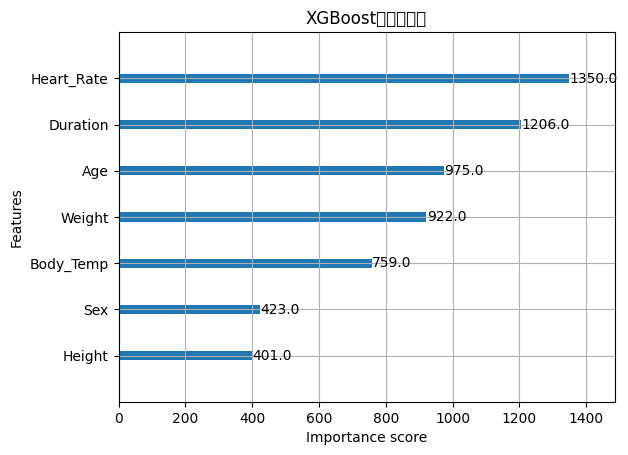

In [33]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

X = train_df.drop(['id', 'Calories'], axis = 1)
y = train_df['Calories']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_valid, label=y_valid)

params = {
    'objective': 'reg:squarederror',  # 回归任务
    'learning_rate': 0.1,
    'max_depth': 6,
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'eta': 0.3,
    'seed': 42
}

# 训练模型
num_rounds = 100
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]
model = xgb.train(params, dtrain, num_rounds, watchlist, early_stopping_rounds=10, verbose_eval=10)

# 在验证集上评估模型
preds = model.predict(dvalid)
rmse = np.sqrt(mean_squared_error(y_valid, preds))
mae = mean_absolute_error(y_valid, preds)
r2 = r2_score(y_valid, preds)

print(f'验证集RMSE: {rmse:.4f}')
print(f'验证集MAE: {mae:.4f}')
print(f'验证集R²: {r2:.4f}')

# 特征重要性可视化
plt.figure(figsize=(10, 6))
xgb.plot_importance(model, max_num_features=10)
plt.title('XGBoost特征重要性')
plt.show()

# 对测试集进行预测（如果需要）
if 'test_df' in locals():
    # 确保测试集有相同的特征（除了Age和id）
    X_test = test_df.drop(['id'], axis=1)
    
    dtest = xgb.DMatrix(X_test)
    test_preds = model.predict(dtest)
    
    # 创建提交文件
    submission = pd.DataFrame({
        'id': test_df['id'],
        'Calories': test_preds
    })
    submission.to_csv('submission.csv', index=False)